# Cats vs Dogs CNN – Colab Notebook
Bu notebook, **blok blok** kodlar ve ayrıntılı Türkçe açıklamalar içerir. Tüm hücreleri sırayla çalıştırarak kedi‑köpek sınıflandırma modelinizi eğitebilirsiniz.

## 🟦 Blok 0 – Gerekli Kütüphaneler
Bu hücre TensorFlow (Keras) ve temel dosya kütüphanelerini içe aktarır.

In [1]:
import tensorflow as tf                      # Derin‑öğrenme çatısı (Keras dâhil)
from tensorflow.keras import layers, models  # Katman ve model kısayolları
import zipfile, os, glob                     # Sıkıştırma & dosya işlemleri

## 🟦 Blok 1 – Veri Kümesini İndir & Aç
Resimleri içeren sıkıştırılmış dosyayı indirip `cats_and_dogs_filtered/` klasörüne çıkarır.

In [ ]:
!wget -q https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

with zipfile.ZipFile("cats_and_dogs_filtered.zip") as z:
    z.extractall()                                       # → cats_and_dogs_filtered/

base_dir  = "cats_and_dogs_filtered"
train_dir = os.path.join(base_dir, "train")              # train/cats & train/dogs
val_dir   = os.path.join(base_dir, "validation")         # validation/cats & validation/dogs

print("Eğitim klasörü:", train_dir)
print("Doğrulama klasörü:", val_dir)

Eğitim klasörü: cats_and_dogs_filtered/train
Doğrulama klasörü: cats_and_dogs_filtered/validation


## 🟦 Blok 2 – Veriyi Dataset'e Dönüştür
Klasör yapısını Keras'ın `image_dataset_from_directory` fonksiyonuna vererek otomatik etiketli bir tf.data dataseti oluştururuz.

In [ ]:
img_size = (160, 160)   # MobileNetV2 için uygun giriş boyutu
batch_sz = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=batch_sz,
    shuffle=True, label_mode="binary")

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, image_size=img_size, batch_size=batch_sz,
    shuffle=False, label_mode="binary")

print("Sınıflar:", train_ds.class_names)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Sınıflar: ['cats', 'dogs']


## 🟦 Blok 3 – Data Augmentation
Modelin farklı varyasyonları görüp genelleme yapabilmesi için rastgele çevirme, döndürme ve yakınlaştırma ekliyoruz.

In [ ]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  # yatay çevir
    layers.RandomRotation(0.1),        # ±10°
    layers.RandomZoom(0.1)             # %10 zoom
])

## 🟦 Blok 4 – Ön Eğitimli Taban (MobileNetV2)
ImageNet üzerinde eğitilmiş evrişim filtrelerini kullanıp yalnızca son katmanları kendimiz ekleyeceğiz.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights="imagenet")
base_model.trainable = False  # ilk turda dondur

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 🟦 Blok 5 – Tam Modelin Kurulması
Veri artırma → önişleme → özellik çıkarımı → global pool → dense → sigmoid sırasıyla modellenir.

In [ ]:
inputs = layers.Input(shape=img_size + (3,))
x = data_aug(inputs)                                           # ① Veri artır
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)     # ② Ölçekle
x = base_model(x, training=False)                              # ③ Sabit filtreler
x = layers.GlobalAveragePooling2D()(x)                         # ④ Özetle
x = layers.Dense(128, activation="relu")(x)                    # ⑤ Dense
outputs = layers.Dense(1, activation="sigmoid")(x)             # ⑥ Çıkış
model = models.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 🟦 Blok 6 – Modeli Derle
Optimizer, kayıp fonksiyonu ve takip metriklerini tanımlıyoruz.

In [ ]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

## 🟦 Blok 7 – İlk Eğitim Turu
Sadece yeni eklediğimiz dense katmanlar eğitilir.

In [ ]:
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9851 - loss: 0.0497 - val_accuracy: 0.9820 - val_loss: 0.0485
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9831 - loss: 0.0613 - val_accuracy: 0.9810 - val_loss: 0.0537
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9841 - loss: 0.0429 - val_accuracy: 0.9690 - val_loss: 0.0897
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9826 - loss: 0.0551 - val_accuracy: 0.9760 - val_loss: 0.0712
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9851 - loss: 0.0321 - val_accuracy: 0.9800 - val_loss: 0.0579



from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    prob = prediction[0][0]
    if prob >= 0.5:
        print(f"Tahmin: Köpek 🐶 (%{prob*100:.2f})")
    else:
        print(f"Tahmin: Kedi 🐱 (%{(1-prob)*100:.2f})")


In [ ]:
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_ft = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 205ms/step - accuracy: 0.8919 - loss: 0.2955 - val_accuracy: 0.9830 - val_loss: 0.0484
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.9488 - loss: 0.1323 - val_accuracy: 0.9840 - val_loss: 0.0490
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.9520 - loss: 0.1192 - val_accuracy: 0.9870 - val_loss: 0.0443
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.9562 - loss: 0.1063 - val_accuracy: 0.9860 - val_loss: 0.0433
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - accuracy: 0.9609 - loss: 0.1003 - val_accuracy: 0.9850 - val_loss: 0.0437


## 🟦 Blok 9 – Tek Resim Tahmini
Val setinden bir resmi modele verip kedi mi köpek mi tahmin ettiğini gözlüyoruz.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
OLASILIK (1=dog): 0.76695836 → DOG


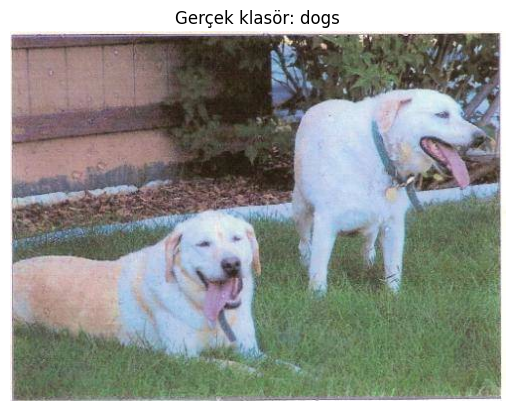

In [ ]:
import numpy as np, PIL.Image as Image, random, matplotlib.pyplot as plt
test_path = random.choice(list(glob.glob(os.path.join(val_dir, "*", "*.jpg"))))
plt.imshow(Image.open(test_path)); plt.axis('off'); plt.title("Gerçek klasör: " + os.path.basename(os.path.dirname(test_path)))
img = Image.open(test_path).resize(img_size)
arr = np.expand_dims(np.array(img) / 255.0, 0)
pred = model.predict(arr)[0][0]
print("OLASILIK (1=dog):", pred, "→", ("DOG" if pred > 0.5 else "CAT"))

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [ ]:
base_dir = '/content/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  # binary classification
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 331ms/step - accuracy: 0.5216 - loss: 0.7984 - val_accuracy: 0.6090 - val_loss: 0.6887
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.5266 - loss: 0.6863 - val_accuracy: 0.5390 - val_loss: 0.6594
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.5836 - loss: 0.6655 - val_accuracy: 0.6190 - val_loss: 0.6609
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.6609 - loss: 0.6399 - val_accuracy: 0.6880 - val_loss: 0.6022
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 241ms/step - accuracy: 0.6592 - loss: 0.6106 - val_accuracy: 0.6310 - val_loss: 0.6228
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.6764 - loss: 0.6113 - val_accuracy: 0.6830 - val_loss: 0.5872
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 257ms/step - accuracy: 0.7107 - loss: 0.5604 - val_accuracy: 0.7050 - val_loss: 0.5683
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.6989 - loss: 0.5560 - val_accu

In [ ]:
model.save('/content/kedi_kopek_modeli.h5')
print("Model başarıyla /content/kedi_kopek_modeli.h5 olarak kaydedildi.")

Model başarıyla /content/kedi_kopek_modeli.h5 olarak kaydedildi.


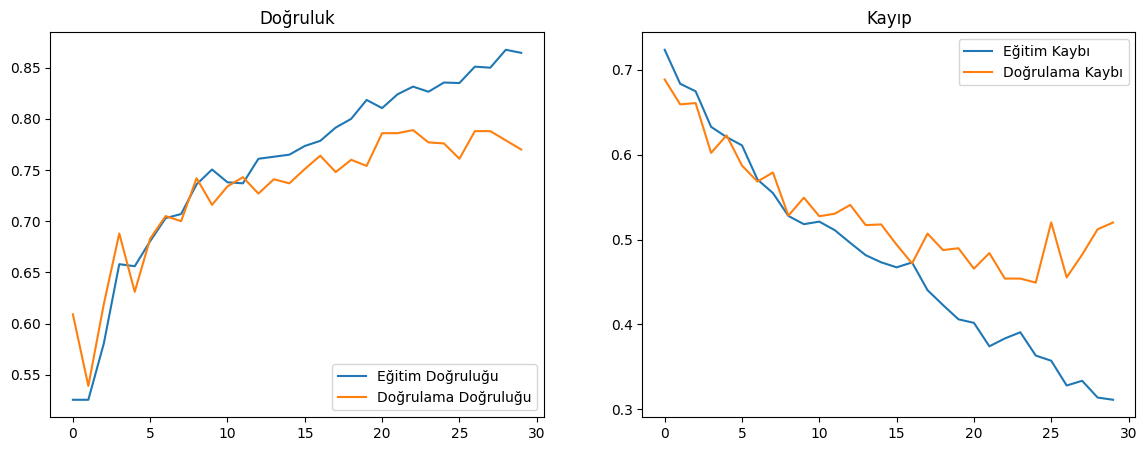

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
plt.legend(loc='lower right')
plt.title('Doğruluk')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Kayıp')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image
from google.colab import files
uploaded = files.upload()  # resmi yükle

for fn in uploaded.keys():
    img_path = fn
    img = image.load_img(img_path, target_size=(150,150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    print(f"Tahmin: {'Köpek 🐶' if prediction[0] > 0.5 else 'Kedi 🐱'} - Güven: {prediction[0][0]:.2f}")


Saving kopekk.jpg to kopekk.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tahmin: Köpek 🐶 - Güven: 1.00
